In [1]:
# Libraries
import pandas as pd
import numpy as np
import math
import datetime as dt
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import scipy.interpolate as interpolate

%matplotlib inline
plt.style.use("seaborn")

In [2]:
# Read in data
load_data = pd.read_csv("data/load_3yback_NE.csv")
weather_data = pd.read_csv("data/weather_3yback_NE.csv")

## Merge the datasets on average hourly load and weather conditions

In [3]:
# Quick look at data
load_data.head()

,Load Region,Source of Data,Local Datetime (Hour Ending),Time Zone,Load Type,Load MW,Load Market,Data Type,Record Count,Local Datetime (Hour Beginning),Month,Hour (Hour Ending 1-24),Day of Week,Holiday (Y/N),Weekday/Weekend,On Peak/Off Peak - EAST,Min Load MW,Max Load MW
0,.Z.CONNECTICUT,NE,10/22/2018 1:00,EDT,LOAD,2470.0,HOURLY,Actual,1,10/22/2018 0:00,10,1,Monday,N,Weekday,Off Peak,2470.0,2470.0
1,.Z.CONNECTICUT,NE,10/22/2018 2:00,EDT,LOAD,2397.0,HOURLY,Actual,1,10/22/2018 1:00,10,2,Monday,N,Weekday,Off Peak,2397.0,2397.0
2,.Z.CONNECTICUT,NE,10/22/2018 3:00,EDT,LOAD,2374.6,HOURLY,Actual,1,10/22/2018 2:00,10,3,Monday,N,Weekday,Off Peak,2374.6,2374.6
3,.Z.CONNECTICUT,NE,10/22/2018 4:00,EDT,LOAD,2392.0,HOURLY,Actual,1,10/22/2018 3:00,10,4,Monday,N,Weekday,Off Peak,2392.0,2392.0
4,.Z.CONNECTICUT,NE,10/22/2018 5:00,EDT,LOAD,2486.2,HOURLY,Actual,1,10/22/2018 4:00,10,5,Monday,N,Weekday,Off Peak,2486.2,2486.2


In [4]:
# Looking at subset of weather reports for Connecticut ISO Zone
weather_data[weather_data['Weather Station Name'] == 'Hartford Brainard Arpt']

,Weather Station Name,Local Datetime (Hour Beginning),Temperature (Dry Bulb) - Fahrenheit,Relative Humidity Percent,Local Datetime (Hour Ending)
26325,Hartford Brainard Arpt,10/22/2018 0:00,34.0,75.0,10/22/2018 1:00
26326,Hartford Brainard Arpt,10/22/2018 1:00,30.9,78.0,10/22/2018 2:00
26327,Hartford Brainard Arpt,10/22/2018 2:00,28.9,89.0,10/22/2018 3:00
26328,Hartford Brainard Arpt,10/22/2018 3:00,30.0,88.0,10/22/2018 4:00
26329,Hartford Brainard Arpt,10/22/2018 4:00,30.9,82.0,10/22/2018 5:00
...,...,...,...,...,...
52645,Hartford Brainard Arpt,10/22/2021 16:00,66.2,56.0,10/22/2021 17:00
52646,Hartford Brainard Arpt,10/22/2021 17:00,64.4,56.0,10/22/2021 18:00
52647,Hartford Brainard Arpt,10/22/2021 18:00,62.6,52.0,10/22/2021 19:00
52648,Hartford Brainard Arpt,10/22/2021 19:00,59.0,59.0,10/22/2021 20:00


Let's include weather station names as variables in our load dataset for merging purposes.
<br>
Mappings are: 
<br>
CONNETICUT - Hartford Brainard Arpt 
<br>
MAINE - Milinocket Arpt
<br>
NEWHAMPSHIRE - St Johnsbury
<br>
RHODEISLAND - Newport State Arpt
<br>
SEMASS - New Bedford Regional Arpt
<br>
VERMONT - Hartness State Springfield Arpt
<br>
WCMASS - Westfield Barnes Municipal Arpt
<br>
NEMASSBOST - Beverly Municipal Arpt

In [5]:
# Drop ISOs in load data I don't have weather data for
load_data = load_data[~load_data["Load Region"].isin([".Z.SEMASS",".Z.WCMASS",".Z.MAINE"])]

In [6]:
# Checking to make sure I have regions for each report
# I will use the variable 'regions' for mapping later
regions = load_data["Load Region"].unique()
regions

array(['.Z.CONNECTICUT', '.Z.NEMASSBOST', '.Z.NEWHAMPSHIRE',
       '.Z.RHODEISLAND', '.Z.VERMONT'], dtype=object)

In [7]:
stations = weather_data["Weather Station Name"].unique()

# Rearrange into correct list
idx = [1,0,4,3,2]
stations = stations[idx]

Creating a function to numerically assign ISO zones to weather regions.

In [8]:
def f(row):
    if row == regions[0]:
        val = stations[0]
    elif row == regions[1]:
        val = stations[1]
    elif row == regions[2]:
        val = stations[2]
    elif row == regions[3]:
        val = stations[3]
    elif row == regions[4]:
        val = stations[4]
    return val

In [9]:
# Adding in weather station mappings
load_data["Weather Station Name"] = load_data["Load Region"].apply(f)

For the purpose of this exercise I will restrict the data to only the Connecticut ISO zone. Note the same procedure can be applied to the other ISO NE regions.

In [10]:
connecticutLoad = load_data[load_data["Load Region"] == '.Z.CONNECTICUT']
len(connecticutLoad)

26256

In [11]:
# Map weather to ISO zone by station name
connecticut = pd.merge(connecticutLoad, weather_data,  how='left', left_on=['Local Datetime (Hour Beginning)','Weather Station Name'], right_on = ['Local Datetime (Hour Beginning)','Weather Station Name'])
len(connecticut)

26256

In [12]:
connecticut.head()

,Load Region,Source of Data,Local Datetime (Hour Ending)_x,Time Zone,Load Type,Load MW,Load Market,Data Type,Record Count,Local Datetime (Hour Beginning),...,Day of Week,Holiday (Y/N),Weekday/Weekend,On Peak/Off Peak - EAST,Min Load MW,Max Load MW,Weather Station Name,Temperature (Dry Bulb) - Fahrenheit,Relative Humidity Percent,Local Datetime (Hour Ending)_y
0,.Z.CONNECTICUT,NE,10/22/2018 1:00,EDT,LOAD,2470.0,HOURLY,Actual,1,10/22/2018 0:00,...,Monday,N,Weekday,Off Peak,2470.0,2470.0,Hartford Brainard Arpt,34.0,75.0,10/22/2018 1:00
1,.Z.CONNECTICUT,NE,10/22/2018 2:00,EDT,LOAD,2397.0,HOURLY,Actual,1,10/22/2018 1:00,...,Monday,N,Weekday,Off Peak,2397.0,2397.0,Hartford Brainard Arpt,30.9,78.0,10/22/2018 2:00
2,.Z.CONNECTICUT,NE,10/22/2018 3:00,EDT,LOAD,2374.6,HOURLY,Actual,1,10/22/2018 2:00,...,Monday,N,Weekday,Off Peak,2374.6,2374.6,Hartford Brainard Arpt,28.9,89.0,10/22/2018 3:00
3,.Z.CONNECTICUT,NE,10/22/2018 4:00,EDT,LOAD,2392.0,HOURLY,Actual,1,10/22/2018 3:00,...,Monday,N,Weekday,Off Peak,2392.0,2392.0,Hartford Brainard Arpt,30.0,88.0,10/22/2018 4:00
4,.Z.CONNECTICUT,NE,10/22/2018 5:00,EDT,LOAD,2486.2,HOURLY,Actual,1,10/22/2018 4:00,...,Monday,N,Weekday,Off Peak,2486.2,2486.2,Hartford Brainard Arpt,30.9,82.0,10/22/2018 5:00


## Filter out variables of interest

Now I'll filter out variables of interest. Also adding variable for the date without hour attached.

In [13]:
# Filter out variables of interest 

# NOTE: Removing min/max load MW b.c. they are the same as the actual load mw in this dataset
cols_to_remove = ['Load Region','Source of Data','Time Zone','Load Type',
                  'Load Market','Data Type','Record Count','Local Datetime (Hour Ending)_x',
                  'Local Datetime (Hour Ending)_y','Min Load MW','Max Load MW']

connecticut = connecticut.drop(cols_to_remove, axis=1)

connecticut.head()

,Load MW,Local Datetime (Hour Beginning),Month,Hour (Hour Ending 1-24),Day of Week,Holiday (Y/N),Weekday/Weekend,On Peak/Off Peak - EAST,Weather Station Name,Temperature (Dry Bulb) - Fahrenheit,Relative Humidity Percent
0,2470.0,10/22/2018 0:00,10,1,Monday,N,Weekday,Off Peak,Hartford Brainard Arpt,34.0,75.0
1,2397.0,10/22/2018 1:00,10,2,Monday,N,Weekday,Off Peak,Hartford Brainard Arpt,30.9,78.0
2,2374.6,10/22/2018 2:00,10,3,Monday,N,Weekday,Off Peak,Hartford Brainard Arpt,28.9,89.0
3,2392.0,10/22/2018 3:00,10,4,Monday,N,Weekday,Off Peak,Hartford Brainard Arpt,30.0,88.0
4,2486.2,10/22/2018 4:00,10,5,Monday,N,Weekday,Off Peak,Hartford Brainard Arpt,30.9,82.0


In [14]:
# Rename columns // makes things easier
col_names = ['LoadMW','LocalDt','M','HourE','DOW','Holiday','DayType','Peak',
             'Station','TempF','Humidity']
connecticut.columns = col_names

In [15]:
# Create new variable for date without hour attached
connecticut["Date"] = connecticut["LocalDt"].apply(
    lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M").strftime('%Y-%m-%d')
)
connecticut["DateTimeObj"] = connecticut["LocalDt"].apply(
    lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M")
)

# Creating variable for year/day. These are helpful for isolating certain times
connecticut["Y"] = connecticut["LocalDt"].apply(
    lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M").strftime('%Y')
)
connecticut["D"] = connecticut["LocalDt"].apply(
    lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M").strftime('%d')
)

## Create additional variables

First generate a variable for the next hour's load. Originally I had also created variables for lagged hourly load, but these proved to be not necessary for the stacked LSTM design used in modeling.

Note for future work: this can easily be extended to t+2, t+3, etc., i.e. can be used to forecast a load profile.

In [16]:
# Ensuring that samples are sorted by time correctly
connecticut = connecticut.sort_values(by = "DateTimeObj")

# Load t+1
LoadMW_Plus1 = connecticut["LoadMW"].shift(periods=-1)
LoadMW_Plus1.name = 'LoadMW_Plus1'

connecticut = pd.concat([connecticut, LoadMW_Plus1], axis=1)

Next I create a one-hot encoding of the $Holiday$ and $Peak$ variables.

In [17]:
# Make dummy for peak/nonpeak
peakDummy = pd.get_dummies(connecticut['Peak'])
connecticut['OnPeak'] = peakDummy['On Peak']

# Make dummy for holiday
holidayDummy = pd.get_dummies(connecticut['Holiday'])
connecticut['Holiday'] = holidayDummy['Y']

My professor recommended that I attempt to include cyclical feature information such as hourly, monthly, or seasonal attributes.

I will create:
- cosine/sine representations of the hour of day (using $HourE$) and month in the year (using $M$)
- a one-hot encoding of season

In [18]:
# Create cosine/sine representation of hour of day

# Normalize HourE values to match with the 0-2π cycle
connecticut["HourE_norm"] = 2 * math.pi * connecticut["HourE"] / connecticut["HourE"].max()

connecticut["cos_HourE"] = np.cos(connecticut["HourE_norm"])
connecticut["sin_HourE"] = np.sin(connecticut["HourE_norm"])

In [19]:
# Create cosine/sine representation of month

# Normalize M values to match with the 0-2π cycle
connecticut["M_norm"] = 2 * math.pi * connecticut["M"] / connecticut["M"].max()

connecticut["cos_M"] = np.cos(connecticut["M_norm"])
connecticut["sin_M"] = np.sin(connecticut["M_norm"])

In [20]:
# Create cosine/sine representation of DOW

# First encode DOW numerically
connecticut["DOW"] = connecticut["DOW"].apply(
    lambda x: time.strptime(x, "%A").tm_wday
)

# Normalize DOW values to match with the 0-2π cycle
connecticut["DOW_norm"] = 2 * math.pi * connecticut["DOW"] / connecticut["DOW"].max()

connecticut["cos_DOW"] = np.cos(connecticut["DOW_norm"])
connecticut["sin_DOW"] = np.sin(connecticut["DOW_norm"])

In [21]:
# Create one-hot encoding of season

# First create season variable
def f(month):
    if month in [12,1,2]:
        return "Winter"
    elif month in [3,4,5]:
        return "Spring"
    elif month in [6,7,8]:
        return "Summer"
    elif month in [9,10,11]:
        return "Fall"

# Adding in season variable
connecticut["Season"] = connecticut["M"].apply(f)

# Make dummies for season and drop 
connecticut = connecticut.join(pd.get_dummies(connecticut['Season']))
connecticut = connecticut.drop("Season", axis = 1)

In [22]:
# Getting final dataframe visual
#df = connecticut[['LocalDt','LoadMW','LoadMW_Plus1','TempF','Humidity','Holiday','Spring','Summer','Winter','Fall','cos_HourE','sin_HourE','cos_DOW','sin_DOW','OnPeak']]
#df.sample(10)

In [23]:
# Final filtering of features
connecticut = connecticut[['LocalDt','Date','DateTimeObj','D','M','Y','LoadMW','LoadMW_Plus1','TempF','Humidity','Holiday','Spring','Summer','Winter','Fall','cos_HourE','sin_HourE','cos_DOW','sin_DOW','OnPeak']]
connecticut.head()

,LocalDt,Date,DateTimeObj,D,M,Y,LoadMW,LoadMW_Plus1,TempF,Humidity,Holiday,Spring,Summer,Winter,Fall,cos_HourE,sin_HourE,cos_DOW,sin_DOW,OnPeak
0,10/22/2018 0:00,2018-10-22,2018-10-22 00:00:00,22,10,2018,2470.0,2397.0,34.0,75.0,0,0,0,0,1,0.965926,0.258819,1.0,0.0,0
1,10/22/2018 1:00,2018-10-22,2018-10-22 01:00:00,22,10,2018,2397.0,2374.6,30.9,78.0,0,0,0,0,1,0.866025,0.500000,1.0,0.0,0
2,10/22/2018 2:00,2018-10-22,2018-10-22 02:00:00,22,10,2018,2374.6,2392.0,28.9,89.0,0,0,0,0,1,0.707107,0.707107,1.0,0.0,0
3,10/22/2018 3:00,2018-10-22,2018-10-22 03:00:00,22,10,2018,2392.0,2486.2,30.0,88.0,0,0,0,0,1,0.500000,0.866025,1.0,0.0,0
4,10/22/2018 4:00,2018-10-22,2018-10-22 04:00:00,22,10,2018,2486.2,2751.4,30.9,82.0,0,0,0,0,1,0.258819,0.965926,1.0,0.0,0


## Data Cleaning

Checking for missing values and any other oddities.

In [24]:
null_data = connecticut[connecticut.isnull().any(axis=1)]
null_data

,LocalDt,Date,DateTimeObj,D,M,Y,LoadMW,LoadMW_Plus1,TempF,Humidity,Holiday,Spring,Summer,Winter,Fall,cos_HourE,sin_HourE,cos_DOW,sin_DOW,OnPeak
15664,8/4/2020 16:00,2020-08-04,2020-08-04 16:00:00,04,8,2020,2886.90,2709.9,NaN,NaN,0,0,1,0,0,-2.588190e-01,-9.659258e-01,0.5,8.660254e-01,1
15665,8/4/2020 17:00,2020-08-04,2020-08-04 17:00:00,04,8,2020,2709.90,2588.3,NaN,NaN,0,0,1,0,0,-1.836970e-16,-1.000000e+00,0.5,8.660254e-01,1
15666,8/4/2020 18:00,2020-08-04,2020-08-04 18:00:00,04,8,2020,2588.30,2536.4,NaN,NaN,0,0,1,0,0,2.588190e-01,-9.659258e-01,0.5,8.660254e-01,1
15667,8/4/2020 19:00,2020-08-04,2020-08-04 19:00:00,04,8,2020,2536.40,2524.4,NaN,NaN,0,0,1,0,0,5.000000e-01,-8.660254e-01,0.5,8.660254e-01,1
15668,8/4/2020 20:00,2020-08-04,2020-08-04 20:00:00,04,8,2020,2524.40,2469.9,NaN,NaN,0,0,1,0,0,7.071068e-01,-7.071068e-01,0.5,8.660254e-01,1
15669,8/4/2020 21:00,2020-08-04,2020-08-04 21:00:00,04,8,2020,2469.90,2299.5,NaN,NaN,0,0,1,0,0,8.660254e-01,-5.000000e-01,0.5,8.660254e-01,1
15670,8/4/2020 22:00,2020-08-04,2020-08-04 22:00:00,04,8,2020,2299.50,2140.5,NaN,NaN,0,0,1,0,0,9.659258e-01,-2.588190e-01,0.5,8.660254e-01,1
15671,8/4/2020 23:00,2020-08-04,2020-08-04 23:00:00,04,8,2020,2140.50,2016.4,NaN,NaN,0,0,1,0,0,1.000000e+00,-2.449294e-16,0.5,8.660254e-01,0
15672,8/5/2020 0:00,2020-08-05,2020-08-05 00:00:00,05,8,2020,2016.40,1942.6,NaN,NaN,0,0,1,0,0,9.659258e-01,2.588190e-01,-0.5,8.660254e-01,0
15673,8/5/2020 1:00,2020-08-05,2020-08-05 01:00:00,05,8,2020,1942.60,1889.1,NaN,NaN,0,0,1,0,0,8.660254e-01,5.000000e-01,-0.5,8.660254e-01,0


I am missing temperature/humidity data from 8/4/20 17:00 to 8/6/20 13:00.

I can handle this by either:
- Deleting rows
- Imputing the data

I decided to look at the graph of hourly data from:
- August of the last year compared to 2020
- July and August of 2020

This is to gauge how similar the various series are. My thought process is that if I see a similar trend in either the year before or in the surrounding months, it may be valid to interpolate those missing days in August 2020.

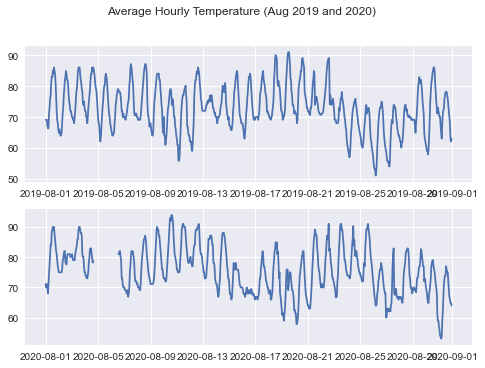

In [25]:
# Aug 2019
df1 = connecticut[(connecticut['Y']=='2019') & (connecticut['M']==8)]

# Aug 2020
df2 = connecticut[(connecticut['Y']=='2020') & (connecticut['M']==8)]

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Average Hourly Temperature (Aug 2019 and 2020)')
ax1.plot(df1.DateTimeObj, df1.TempF)
ax2.plot(df2.DateTimeObj, df2.TempF)

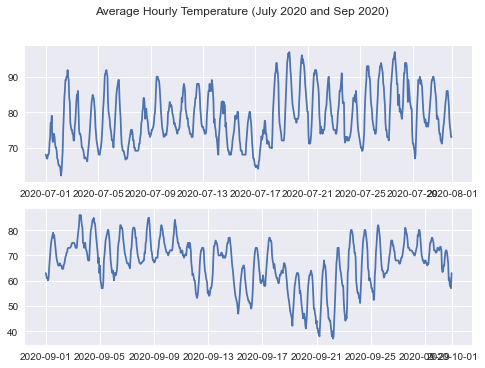

In [26]:
# July
df3 = connecticut[(connecticut['Y']=='2020') & (connecticut['M']==7)]

# Sep
df4 = connecticut[(connecticut['Y']=='2020') & (connecticut['M']==9)]

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Average Hourly Temperature (July 2020 and Sep 2020)')
ax1.plot(df3.DateTimeObj, df3.TempF)
ax2.plot(df4.DateTimeObj, df4.TempF)

The lack of a consistent trend in the same month of the past year, and surrounding months of the current year, has me wary of interpolating these values. It seems safest to drop any samples without a value for average temperature.

In [27]:
# Drop these samples
connecticut = connecticut.dropna()

## Data Visualization

Creating some charts to get a better feel of the data.

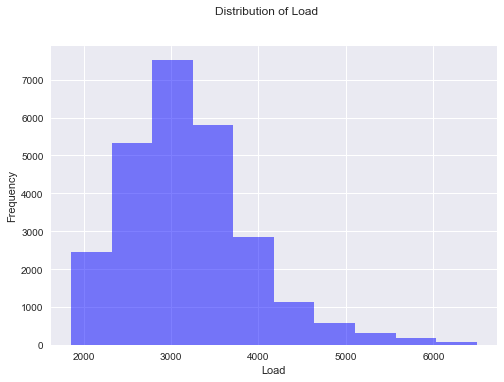

In [28]:
# Distribution of load 
plt.xlabel("Load")
plt.ylabel("Frequency")
num_bins = 10
plt.suptitle('Distribution of Load')
n, bins, patches = plt.hist(connecticut['LoadMW'], num_bins, facecolor='blue', alpha=0.5)
plt.show()

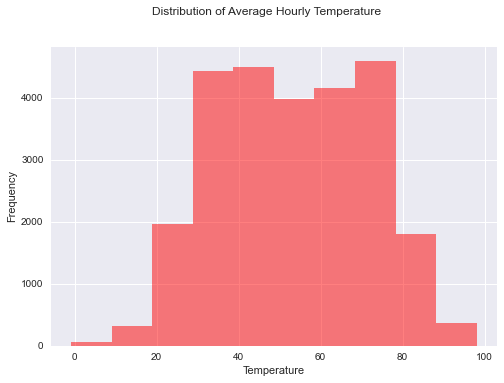

In [29]:
# Distribution of temperature
plt.xlabel("Temperature")
plt.ylabel("Frequency")
num_bins = 10
plt.suptitle('Distribution of Average Hourly Temperature')
n, bins, patches = plt.hist(connecticut['TempF'], num_bins, facecolor='red', alpha=0.5)
plt.show()

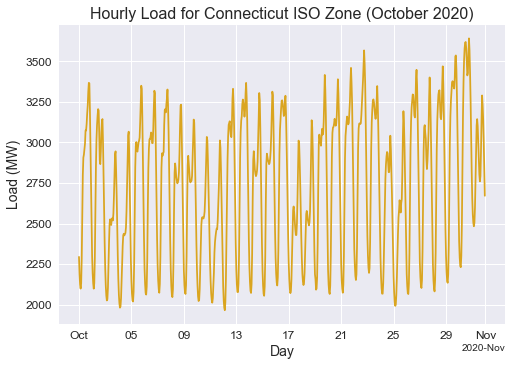

In [30]:
# Showing seasonality effect

# Aug 2020
aug20 = connecticut[(connecticut['Y']=='2020') & (connecticut['M']==10)]

fig, axs = plt.subplots()

locator = matplotlib.dates.AutoDateLocator(minticks=7, maxticks=15)
formatter = matplotlib.dates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

axs.plot(aug20["DateTimeObj"], aug20["LoadMW"], color='goldenrod')

axs.set_title('Hourly Load for Connecticut ISO Zone (October 2020)', fontdict = {'fontsize' : 16})
axs.set_xlabel("Day", fontdict = {'fontsize' : 14})
axs.set_ylabel("Load (MW)", fontdict = {'fontsize' : 14})

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()
#plt.savefig('figures/oct_2020_ts.eps', format='eps')

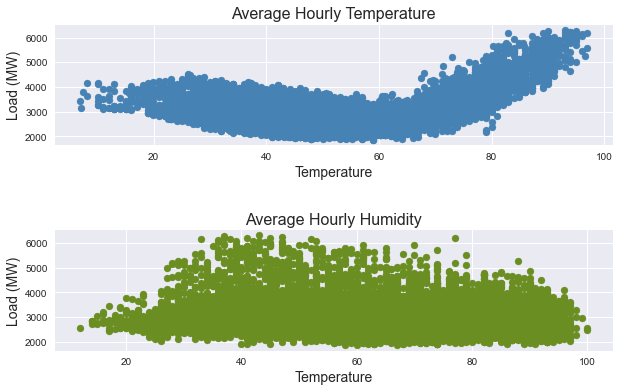

In [31]:
# Showing nonlinearity of features with target

# Randomly choosing November 2020
df3 = connecticut[(connecticut['Y']=='2020')]
df4 = connecticut[(connecticut['Y']=='2020')]

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 6))
fig.subplots_adjust(wspace=0.4, hspace=0.7)

ax1.scatter(df3.TempF, df3.LoadMW_Plus1, color='steelblue')
ax1.set_xlabel("Temperature", fontdict = {'fontsize' : 14})
ax1.set_ylabel("Load (MW)", fontdict = {'fontsize' : 14})
ax1.set_title("Average Hourly Temperature", fontdict = {'fontsize' : 16})

ax2.scatter(df4.Humidity, df4.LoadMW_Plus1, color='olivedrab')
ax2.set_xlabel("Temperature", fontdict = {'fontsize' : 14})
ax2.set_ylabel("Load (MW)", fontdict = {'fontsize' : 14})
ax2.set_title("Average Hourly Humidity", fontdict = {'fontsize' : 16})

plt.show()
#plt.savefig('figures/temp_humid_scatter.eps', format='eps')

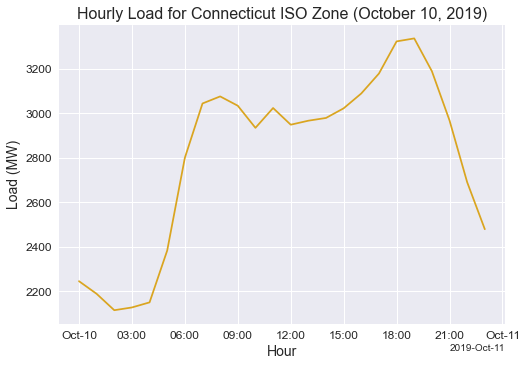

In [32]:
# Showing periods of rapid fluctuation

# Aug 2020
df2 = connecticut[(connecticut['Y']=='2019') & (connecticut['M']==10) & (connecticut['D'].isin(['10']))]

fig, axs = plt.subplots()

locator = matplotlib.dates.AutoDateLocator(minticks=7, maxticks=10)
formatter = matplotlib.dates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

axs.plot(df2["DateTimeObj"], df2["LoadMW"], color='goldenrod')

axs.set_title('Hourly Load for Connecticut ISO Zone (October 10, 2019)', fontdict = {'fontsize' : 16})
axs.set_xlabel("Hour", fontdict = {'fontsize' : 14})
axs.set_ylabel("Load (MW)", fontdict = {'fontsize' : 14})

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.show()
plt.savefig('figures/oct10_19_ts.eps', format='eps')

In [33]:
# Remove duplicate values
connecticut = connecticut.drop_duplicates('LocalDt',keep='last')

Save this CSV and do model building in a separate notebook.

In [34]:
# Writing CSV
#connecticut.to_csv('data/connecticutData.csv', index=False)